In [1]:
import torch
from torch.autograd import Variable

## Simultaneous search for policy and verifying Lyapunov function

$$\dot{x} = f(x,u)$$

$$ u = \pi_\theta(x)) $$

$$ V(x) = p.s.d. \text{by construction, but parameterized by parameters } \psi $$

$$ \dot{V} = \frac{dV}{dx} \dot{x}$$
$$ = \big[ \frac{dV}{dx}\big]^T \big[f(x,\pi_{\theta}(x) \big] $$

### Loss function

$X$ = {$x_1, x_2, ..., x_N$} many samples

$$ L(\theta) = \sum_{i} l(x_i, \theta) $$

\begin{equation}
  \mathcal{l}(x_i,\theta) =
  \begin{cases}
    \dot{V}(x_i, \theta) & \text{if $\dot{V}(x_i, \theta) > 0$} \\
    0 & \text{otherwise}
  \end{cases}
\end{equation}



In [2]:
x_i = Variable(torch.FloatTensor([1.0, 1.1]), requires_grad=True)
print x_i

### Step 1: compute V(x)
P_size = 16
P = Variable(torch.ones(P_size), requires_grad=True)

def compute_V(x):
    V_monomials = Variable(torch.zeros(P_size))
    V_monomials[0] = x[0]
    V_monomials[1] = x[0]**2
    V_monomials[2] = x[0]**3
    V_monomials[3] = x[1]
    V_monomials[4] = x[1]**2
    V_monomials[5] = x[1]**3
    V_monomials[6] = torch.cos(x[0])
    V_monomials[7] = torch.cos(x[0]).pow(2)
    V_monomials[8] = torch.sin(x[0])
    V_monomials[9] = torch.sin(x[0]).pow(2)
    # mixed terms
    V_monomials[10] = x[0]*x[1]
    V_monomials[11] = x[0]*torch.cos(x[0])
    V_monomials[12] = x[0]*torch.sin(x[0])
    V_monomials[13] = torch.sin(x[0])*torch.cos(x[0])
    V_monomials[14] = x[1]*torch.cos(x[0])
    V_monomials[15] = x[1]*torch.sin(x[0])
    v = torch.dot(P, V_monomials)
    return v

### Step 2: compute dV/dx

### Step 3: initialize policy parameters
K_size = 16
K = Variable(torch.ones(K_size), requires_grad=True)
print K

## parameters

l = 30.0   # length in pixels
g = 9.8    # gravity in m/s**2
m = 1.0    # mass in kg
b = 10.0    # damping

def policy(x):
    monomials = Variable(torch.zeros(K_size))
    monomials[0] = x[0]
    monomials[1] = x[0]**2
    monomials[2] = x[0]**3
    monomials[3] = x[1]
    monomials[4] = x[1]**2
    monomials[5] = x[1]**3
    monomials[6] = torch.cos(x[0])
    monomials[7] = torch.cos(x[0]).pow(2)
    monomials[8] = torch.sin(x[0])
    monomials[9] = torch.sin(x[0]).pow(2)
    # mixed terms
    monomials[10] = x[0]*x[1]
    monomials[11] = x[0]*torch.cos(x[0])
    monomials[12] = x[0]*torch.sin(x[0])
    monomials[13] = torch.sin(x[0])*torch.cos(x[0])
    monomials[14] = x[1]*torch.cos(x[0])
    monomials[15] = x[1]*torch.sin(x[0])
    u = torch.dot(K, monomials)
    return u
    
### Step 4: define dynamics function
def dynamics(x):
    xdot = Variable(torch.zeros(2))
    xdot[0] = x[1]
    u = policy(x)
    xdot[1] = -(m * g * l * torch.sin(x[0:1])) - b*x[1] + u
    return xdot

xdot = dynamics(x_i)
print xdot

### Step 5: compute Vdot

def compute_Vdot(x):
    V = compute_V(x)
    V.backward(torch.FloatTensor([1.0]),retain_graph=True)
    jacobian_x = Variable(x.grad.data)
    f = dynamics(x)
    Vdot = torch.dot(jacobian_x,f)
    return Vdot
    
Vdot = compute_Vdot(x_i)
print Vdot
Vdot.backward()

Variable containing:
 1.0000
 1.1000
[torch.FloatTensor of size 2]

Variable containing:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
[torch.FloatTensor of size 16]

Variable containing:
   1.1000
-244.9133
[torch.FloatTensor of size 2]

Variable containing:
-2248.2407
[torch.FloatTensor of size 1]



## Let's test for a K
 
K = [1, 2] shouldn't be stable?

In [3]:
K = Variable(torch.ones(K_size), requires_grad=True)
for i in range(10000):
    x_i = Variable(torch.randn(2), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

false, counterexample found:  Variable containing:
-0.1050
 1.1753
[torch.FloatTensor of size 2]



## Now let's search for K, from an initialization not stable

In [4]:
K = Variable(torch.ones(K_size), requires_grad=True)

for i in range(10000):
    x_i = Variable(torch.randn(2), requires_grad=True)
    Vdot = compute_Vdot(x_i)
    if Vdot.data[0] > 0:
        print "false, counterexample found: ", x_i
        break

false, counterexample found:  Variable containing:
-1.0080
 1.4667
[torch.FloatTensor of size 2]



<IPython.core.display.Javascript object>


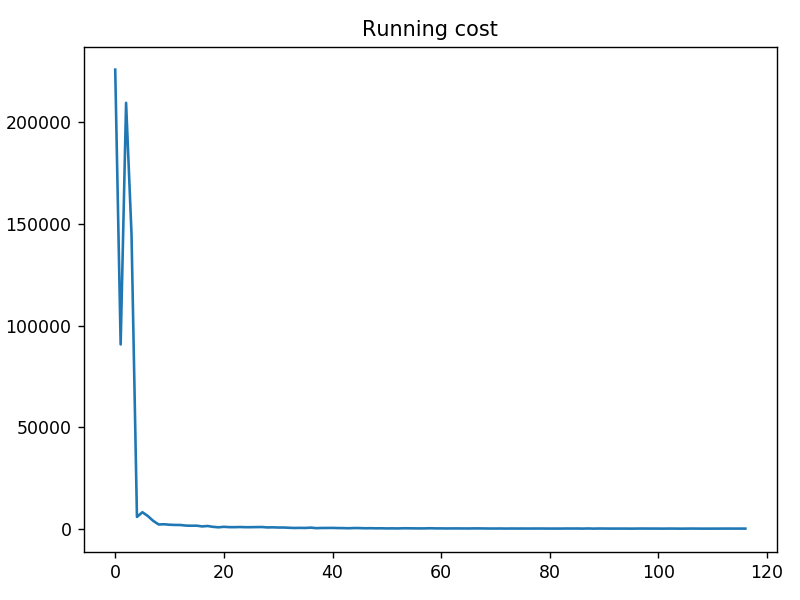

In [5]:
## optimization plotting tool
%matplotlib notebook
import matplotlib.pyplot as plt 

cost_current_iteration = 0
cost_history = []
cost_iteration_number_history = []

f, (cost_axis) = plt.subplots(1, 1)

cost_axis.plot(cost_iteration_number_history, cost_history)
cost_axis.set_title('Running cost')

plt.tight_layout()

In [6]:
## optimize

num_iterations = 1000
step_rate = 1e-2

# K has already been initialized above, and initial policy visualized
print K

for cost_iteration in range(num_iterations):
    
    cost = 0
    
    for i in range(1000):
        x_i = Variable(torch.randn(2), requires_grad=True)
        Vdot = compute_Vdot(x_i)
        cost += Vdot.clamp(min=0)
        
    ## Automatically differentiate
    cost.backward()

    # Update P and K via gradient descent
    K.data -= step_rate * K.grad.data
    P.data -= step_rate * P.grad.data
      
    # Manually zero the gradients after running the backward pass
    K.grad.data.zero_()
    P.grad.data.zero_()
    
    # handle plotting
    cost_history.append(cost.data[0])
    cost_iteration_number_history.append(cost_iteration)
    
    if cost_iteration % 1 == 0:
        cost_axis.lines[0].set_xdata(cost_iteration_number_history)
        cost_axis.lines[0].set_ydata(cost_history)
        cost_axis.relim()
        cost_axis.autoscale_view()
        cost_axis.figure.canvas.draw()
        
    if cost.data[0] == 0:
        break
        
    print K, cost.data[0]
    
print K

Variable containing:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
[torch.FloatTensor of size 16]

Variable containing:
 10.3676
 -8.5813
 12.1755
 -4.2512
-40.3902
 12.5252
-11.3175
-10.2659
  8.6759
 -4.0741
  2.6019
  5.6324
 -5.6774
  5.4389
 -4.1058
  2.4658
[torch.FloatTensor of size 16]
 225935.0
Variable containing:
 17.1482
-21.8823
  5.4934
-15.8988
-69.3142
-38.2746
-17.7851
-16.1756
 15.7469
 -9.6013
 10.6097
 11.9936
-12.9568
  9.5737
 -9.5474
 10.1916
[torch.FloatTensor of size 16]
 90676.515625
Variable containing:
  20.8131
 -26.5662
  10.0443
  -3.6157
-104.1399
  58.9966
 -24.1075
 -21.7728
  18.7249
 -12.3758
   7.5814
  13.7403
 -16.5038
  11.2557
  -0.1775
   8.3109
[torch.FloatTensor of size 16]
 209588.34375
Variable containing:
  22.6356
 -36.0270
  -0.4061
 -22.3774
-145.6488
 -41.8972
 -30.7666
 -27.5348
  21.5599
 -16.9240
   7.9867
  17.4379
 -22.1332
  13.3744
 -11.2164
  10.1039
[torch.FloatTensor of size 16]
 144903.359375
Variable containing:
  23.3892

Variable containing:
  33.0903
 -39.0819
 -14.6191
 -21.9284
-155.1405
 -19.4348
 -43.9211
 -35.7944
  32.9581
 -25.2210
  10.0043
  28.5168
 -31.3588
  21.0217
  -9.3913
  10.7340
[torch.FloatTensor of size 16]
 538.426757812
Variable containing:
  33.2348
 -39.1898
 -14.5326
 -21.9275
-155.1564
 -19.4325
 -44.0761
 -35.9145
  33.0888
 -25.3068
  10.0104
  28.6209
 -31.4549
  21.1169
  -9.3859
  10.7381
[torch.FloatTensor of size 16]
 273.726715088
Variable containing:
  33.3022
 -39.1000
 -14.9660
 -21.9721
-155.1350
 -19.4724
 -44.2447
 -35.9968
  33.2043
 -25.3904
  10.1021
  28.7917
 -31.5146
  21.2240
  -9.3680
  10.7741
[torch.FloatTensor of size 16]
 355.081665039
Variable containing:
  33.4822
 -39.2001
 -15.0053
 -22.0032
-155.1555
 -19.4713
 -44.4363
 -36.1189
  33.3829
 -25.5209
  10.1226
  28.9539
 -31.6519
  21.3514
  -9.3941
  10.8022
[torch.FloatTensor of size 16]
 373.104614258
Variable containing:
  33.6586
 -39.3191
 -14.9311
 -22.0229
-155.1574
 -19.4907
 -44.6380
 

Variable containing:
  36.6897
 -40.9177
 -16.1605
 -22.7900
-155.1697
 -19.9500
 -47.7754
 -38.1673
  36.5990
 -27.9185
  11.4109
  31.8866
 -34.2016
  23.5889
  -9.3836
  11.4982
[torch.FloatTensor of size 16]
 107.906745911
Variable containing:
  36.7472
 -40.9457
 -16.1808
 -22.8277
-155.1561
 -19.9776
 -47.8377
 -38.2036
  36.6577
 -27.9624
  11.4691
  31.9441
 -34.2432
  23.6354
  -9.3844
  11.5331
[torch.FloatTensor of size 16]
 85.6955413818
Variable containing:
  36.7604
 -40.8784
 -16.4424
 -22.8486
-155.1377
 -20.0016
 -47.9014
 -38.2275
  36.6996
 -27.9934
  11.5140
  32.0187
 -34.2632
  23.6760
  -9.3760
  11.5448
[torch.FloatTensor of size 16]
 97.0728302002
Variable containing:
  36.8268
 -40.9387
 -16.3844
 -22.8594
-155.1428
 -20.0022
 -47.9497
 -38.2600
  36.7568
 -28.0371
  11.5254
  32.0587
 -34.3143
  23.7114
  -9.3813
  11.5541
[torch.FloatTensor of size 16]
 79.0562667847
Variable containing:
  36.8231
 -40.8786
 -16.5510
 -22.8874
-155.1154
 -20.0361
 -47.9964
 

Variable containing:
  38.0996
 -41.4563
 -17.2148
 -23.2948
-154.9713
 -20.3129
 -49.4119
 -39.1084
  38.0963
 -29.0315
  12.1326
  33.4061
 -35.2651
  24.7555
  -9.4566
  11.9726
[torch.FloatTensor of size 16]
 44.7961769104
Variable containing:
  38.0862
 -41.3818
 -17.4252
 -23.3229
-154.9439
 -20.3474
 -49.4478
 -39.1156
  38.1089
 -29.0411
  12.1894
  33.4546
 -35.2561
  24.7817
  -9.4453
  11.9947
[torch.FloatTensor of size 16]
 49.4546852112
Variable containing:
  38.1124
 -41.3778
 -17.4945
 -23.3302
-154.9405
 -20.3529
 -49.4862
 -39.1334
  38.1422
 -29.0671
  12.1968
  33.4951
 -35.2786
  24.8087
  -9.4490
  12.0032
[torch.FloatTensor of size 16]
 61.3190155029
Variable containing:
  38.1467
 -41.3842
 -17.5448
 -23.3353
-154.9379
 -20.3547
 -49.5299
 -39.1568
  38.1814
 -29.0965
  12.1983
  33.5377
 -35.3059
  24.8396
  -9.4550
  12.0091
[torch.FloatTensor of size 16]
 73.8272857666
Variable containing:
  38.1720
 -41.3726
 -17.6432
 -23.3430
-154.9353
 -20.3568
 -49.5692
 

KeyboardInterrupt: 

In [7]:
print P

Variable containing:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
[torch.FloatTensor of size 16]



In [ ]:
K

Variable containing:
  38.0862
 -41.3818
 -17.4252
 -23.3229
-154.9439
 -20.3474
 -49.4478
 -39.1156
  38.1089
 -29.0411
  12.1894
  33.4546
 -35.2561
  24.7817
  -9.4453
  11.9947
[torch.FloatTensor of size 16]
 49.4546852112